In [1]:
import numpy as np
import scipy.sparse
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import StratifiedShuffleSplit

In [2]:
import matplotlib.pyplot as plt
%matplotlib nbagg
import seaborn as sns
sns.set(style='darkgrid')

/home/bmcfee/miniconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
import lightfm

In [4]:
import pandas as pd

In [5]:
import gzip

In [6]:
import sklearn.metrics

In [7]:
from joblib import Parallel, delayed

In [8]:
import copy
def _score(model, user_id, pid_array, row, no_items):
    
    uid_array = np.empty(no_items, dtype=np.int32)
    uid_array.fill(user_id)
    
    #model = copy.deepcopy(model)
    
    #predictions = model.predict(uid_array, pid_array, num_threads=1)
    predictions = model.item_embeddings.dot(model.user_embeddings[user_id]) + model.item_biases
    
    truth = np.asarray(row.todense()).ravel()
        
    mean_ap = sklearn.metrics.average_precision_score(truth, predictions)
    auc = sklearn.metrics.roc_auc_score(truth, predictions)
    
    return mean_ap, auc

def _val(model, user_id, pid_array, train_row, test_row):
    
    no_items = test_row.shape[1]
    uid_array = np.empty(no_items, dtype=np.int32)
    uid_array.fill(user_id)
    
    predictions = model.item_embeddings.dot(model.user_embeddings[user_id]) + model.item_biases
    
    truth = np.asarray(test_row.todense()).ravel()
    
    # Now slice out everything in the training set
    
    idx = np.asarray(train_row.todense().astype(np.bool)).ravel()
    
    predictions = predictions[~idx]
    truth = truth[~idx]
    
    mean_ap = sklearn.metrics.average_precision_score(truth, predictions)
    auc = sklearn.metrics.roc_auc_score(truth, predictions)
    
    return mean_ap, auc


def pscore_model(model, ground_truth, num_threads=4):
    
    ground_truth = ground_truth.tocsr()
    
    no_users, no_items = ground_truth.shape
    
    pid_array = np.arange(no_items, dtype=np.int32)
    
    scores = Parallel(n_jobs=num_threads, verbose=1)(delayed(_score)(model, user_id, pid_array, row, no_items)
                                         for user_id, row in enumerate(ground_truth))
    
    return pd.DataFrame(data=scores, columns=['mean_ap', 'auc'])

def validate_model(model, train, test, num_threads=4):
    
    train = train.tocsr()
    test = test.tocsr()
    
    no_users, no_items = test.shape
    
    pid_array = np.arange(no_items, dtype=np.int32)
    
    scores = Parallel(n_jobs=num_threads, verbose=1)(delayed(_val)(model, user_id, pid_array, train_row, test_row)
                                         for user_id, (train_row, test_row) in enumerate(zip(train, test)))
    
    return pd.DataFrame(data=scores, columns=['mean_ap', 'auc'])

def score_model(model, ground_truth, num_threads=4):
    
    ground_truth = ground_truth.tocsr()
    
    no_users, no_items = ground_truth.shape
    
    pid_array = np.arange(no_items, dtype=np.int32)
    
    mean_ap = []
    auc = []
    
    for user_id, row in enumerate(ground_truth):
        
        uid_array = np.empty(no_items, dtype=np.int32)
        uid_array.fill(user_id)
        
        predictions = model.predict(uid_array, pid_array, num_threads=num_threads)
        
        truth = np.asarray(row.todense()).ravel()
        
        mean_ap.append(sklearn.metrics.average_precision_score(truth, predictions))
        auc.append(sklearn.metrics.roc_auc_score(truth, predictions))
        
    return pd.DataFrame(data={'mean_ap': mean_ap, 'auc': auc})

In [9]:
# Load in the cf data
cfdata_all = pd.read_csv(gzip.open('/home/bmcfee/data/1mil/cf/train_triplets.txt.gz', 'r'), sep='\t', header=None)

cfdata_all.columns = ['user_id', 'song_id', 'count']

In [10]:
bad_songs = pd.read_csv('/home/bmcfee/data/1mil/AdditionalFiles/sid_mismatches.csv', header=None)[0]

In [11]:
# Load the song<->track mapping
unique_tracks = pd.read_csv('/home/bmcfee/data/1mil/AdditionalFiles/unique_tracks.txt', index_col=0, header=None, sep='<SEP>')

unique_tracks.columns = ['song_id', 'artist', 'title']
unique_tracks.index.name = 'track_id'

/home/bmcfee/miniconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators; you can avoid this warning by specifying engine='python'.
  from ipykernel import kernelapp as app


In [12]:
# Load the artist mapping
unique_artists = pd.read_csv('/home/bmcfee/data/1mil/AdditionalFiles/unique_artists.txt', index_col=0, header=None, sep='<SEP>')

unique_artists.columns = ['mbid', 'track_id', 'artist']
unique_artists.index.name = 'artist_id'

/home/bmcfee/miniconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators; you can avoid this warning by specifying engine='python'.
  from ipykernel import kernelapp as app


In [13]:
# Load the test split
test_artists = pd.read_csv('/home/bmcfee/data/1mil/AdditionalFiles/artists_test.txt', index_col=0, header=None)
test_artists.index.name = 'artist_id'

In [14]:
test_tracks = test_artists.join(unique_artists)
test_songs = test_tracks.join(unique_tracks, on='track_id', rsuffix=' ', how='inner')

In [15]:
bad_songs = bad_songs.append(test_songs['song_id'])

In [16]:
# Now the songs are only in the msd training split, and not including the mismatches

In [17]:
cfdata_all = cfdata_all[~cfdata_all['song_id'].isin(bad_songs)]

In [18]:
song_counts = cfdata_all.groupby('song_id')['count'].sum()

song_counts.sort_values(inplace=True)

In [19]:
songs = song_counts.tail(10000)

In [20]:
good_records = cfdata_all[cfdata_all['song_id'].isin(songs.index)]

In [21]:
users = good_records.groupby('user_id')['song_id'].count()

users.sort_values(inplace=True)

In [22]:
good_users = users[users >= 100]

In [23]:
good_data = good_records[good_records['user_id'].isin(good_users.index)]

In [24]:
len(good_data['user_id'].unique())

25237

In [25]:
len(good_data['song_id'].unique())

10000

In [26]:
good_data = good_data.reset_index(drop=True)

In [27]:
# Convert to a sparse matrix

In [28]:
ux = LabelEncoder()
ux.fit(good_data['user_id'].unique())

ix = LabelEncoder()
ix.fit(good_data['song_id'].unique())

LabelEncoder()

In [29]:
good_data['user_index'] = ux.transform(good_data['user_id'])
good_data['item_index'] = ix.transform(good_data['song_id'])

In [30]:
# Randomly partition ratings
for train_idx, test_idx in StratifiedShuffleSplit(good_data['user_index'], n_iter=1, test_size=0.2, random_state=0):
    pass

In [31]:
train = scipy.sparse.coo_matrix( (np.ones(len(good_data.loc[train_idx]['count']), dtype=np.int32), 
                                  (good_data.loc[train_idx]['user_index'], good_data.loc[train_idx]['item_index'])))

In [32]:
test = scipy.sparse.coo_matrix( (np.ones(len(good_data.loc[test_idx]['count']), dtype=np.int32), 
                                  (good_data.loc[test_idx]['user_index'], good_data.loc[test_idx]['item_index'])))

In [33]:
scores = []
models = []
for n_components in [8, 16, 32, 64, 128]:
    print("Fitting d={:d}".format(n_components))
    model = lightfm.LightFM(no_components=n_components, loss='warp', item_alpha=1e-6, user_alpha=1e-6)
    model.fit(train, epochs=20, num_threads=3, verbose=False)
    models.append(model)

Fitting d=8
Fitting d=16
Fitting d=32
Fitting d=64
Fitting d=128


In [34]:
for model in models:
    print("Evaluating d={:d}".format(model.item_embeddings.shape[1]))
    score_test = validate_model(model, train.tocsr(), test.tocsr())
    print(score_test.mean())
    scores.append(score_test)
    print('---')

Evaluating d=8


[Parallel(n_jobs=4)]: Done 144 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 744 tasks      | elapsed:   11.4s
[Parallel(n_jobs=4)]: Done 1744 tasks      | elapsed:   24.8s
[Parallel(n_jobs=4)]: Done 3144 tasks      | elapsed:   44.7s
[Parallel(n_jobs=4)]: Done 4944 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 7144 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 9744 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 12744 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done 16144 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 19944 tasks      | elapsed:  4.9min
[Parallel(n_jobs=4)]: Done 24144 tasks      | elapsed:  5.9min
[Parallel(n_jobs=4)]: Done 25237 out of 25237 | elapsed:  6.2min finished


mean_ap    0.115469
auc        0.889773
dtype: float64
---
Evaluating d=16


[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done 1480 tasks      | elapsed:   14.1s
[Parallel(n_jobs=4)]: Done 3480 tasks      | elapsed:   33.2s
[Parallel(n_jobs=4)]: Done 6280 tasks      | elapsed:   58.3s
[Parallel(n_jobs=4)]: Done 9880 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 14280 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 19480 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done 25237 out of 25237 | elapsed:  4.1min finished


mean_ap    0.131015
auc        0.903726
dtype: float64
---
Evaluating d=32


[Parallel(n_jobs=4)]: Done 348 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 1848 tasks      | elapsed:   14.3s
[Parallel(n_jobs=4)]: Done 4348 tasks      | elapsed:   35.3s
[Parallel(n_jobs=4)]: Done 7848 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 12348 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 17848 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 24348 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 25237 out of 25237 | elapsed:  3.6min finished


mean_ap    0.144149
auc        0.912000
dtype: float64
---
Evaluating d=64


[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 1480 tasks      | elapsed:   14.6s
[Parallel(n_jobs=4)]: Done 3480 tasks      | elapsed:   32.8s
[Parallel(n_jobs=4)]: Done 6280 tasks      | elapsed:   56.1s
[Parallel(n_jobs=4)]: Done 9880 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 14280 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 19480 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 25237 out of 25237 | elapsed:  3.5min finished


mean_ap    0.152043
auc        0.914724
dtype: float64
---
Evaluating d=128


[Parallel(n_jobs=4)]: Done 212 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 1112 tasks      | elapsed:   10.1s
[Parallel(n_jobs=4)]: Done 2612 tasks      | elapsed:   23.7s
[Parallel(n_jobs=4)]: Done 4712 tasks      | elapsed:   42.5s
[Parallel(n_jobs=4)]: Done 7412 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 10712 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 14612 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 19112 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done 24212 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 25237 out of 25237 | elapsed:  3.8min finished


mean_ap    0.145139
auc        0.911032
dtype: float64
---


---

In [40]:
model = models[np.argmax([s['mean_ap'].mean() for s in scores])]

In [47]:
import pickle

In [53]:
with open('cf_target_data.pickle', 'wb') as fdesc:
    pickle.dump({'models': models, 'ux': ux, 'ix': ix, 'best_model': model}, fdesc)

<IPython.core.display.Javascript object>


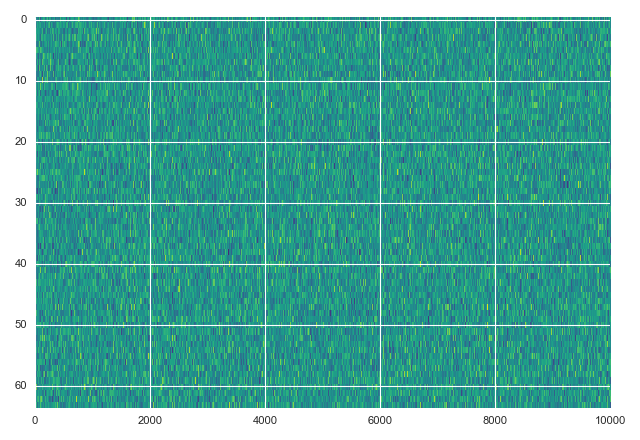

In [41]:
plt.figure()
plt.imshow(model.item_embeddings.T, aspect='auto', interpolation='nearest', cmap='viridis')
plt.tight_layout();

<IPython.core.display.Javascript object>


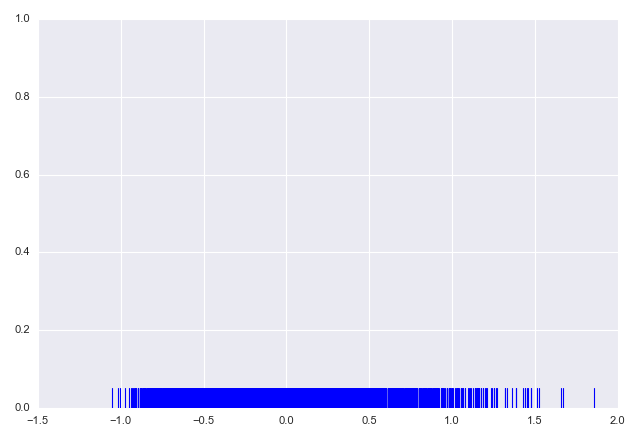

In [42]:
plt.figure()
sns.rugplot(model.item_biases)
plt.tight_layout()

In [43]:
from sklearn.manifold import TSNE

In [44]:
T = TSNE(random_state=0, verbose=1)

In [45]:
Y = T.fit_transform(model.item_embeddings)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.737825
[t-SNE] Error after 100 iterations with early exaggeration: 1.453623
[t-SNE] Error after 300 iterations: 1.403868


<IPython.core.display.Javascript object>


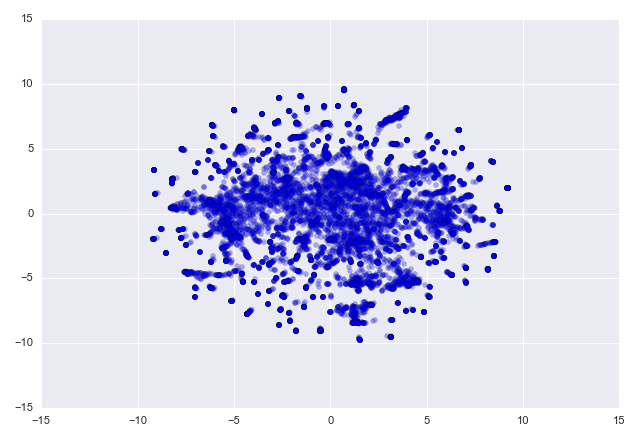

In [46]:
plt.figure()
plt.scatter(Y[:, 0], Y[:, 1], alpha=0.3)
plt.tight_layout();